In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib
import seaborn as sns
import pynbody 
from sklearn.metrics import confusion_matrix

import torch 
import torch.nn as nn
import torch.utils.data as data
import torch.nn.functional as F
from nflows import transforms
from torchvision.transforms.functional import resize
from nflows.transforms.base import Transform

# Put cataloge (AHF) and simulation (output) in the same folder

# Load the simuation

In [2]:
s = pynbody.load('data/g8.26e11/snap_2000/output/8.26e11.02000') #this is a SimSnap
h = s.halos() #this is a cataloghue

In [3]:
print('number of particles in h[1]:', len(h[1]))
print('number of particles in h[-1]:', len(h[len(h)]))

number of particles in h[1]: 9579299
number of particles in h[-1]: 50


In [4]:
s.physical_units()

In [5]:
h1 = h[1]
print('len star', len(h1.s), '\t', 'len gas', len(h1.g), '\t', 'len dark matter', len(h1.d))
print('total number of particles', (len(h1.s) + len(h1.g) + len(h1.d)))

len star 4171413 	 len gas 1665173 	 len dark matter 3742713
total number of particles 9579299


# Plot 
halos must be centered before plotting

### Plot of h1 (main halo)

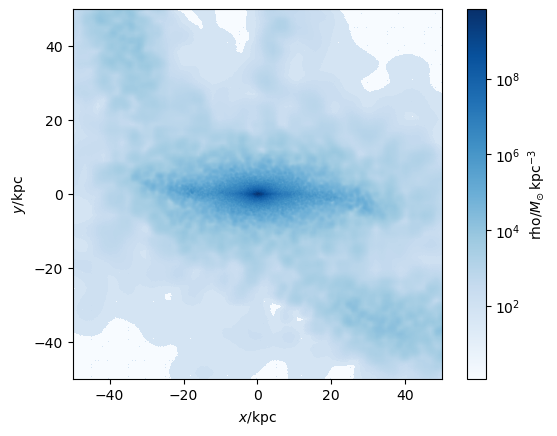

In [6]:
#Edge on
pynbody.analysis.halo.center(h1,mode='hyb')
pynbody.analysis.angmom.sideon(h[1])
pynbody.plot.image(h1.s, width=100, cmap='Blues');

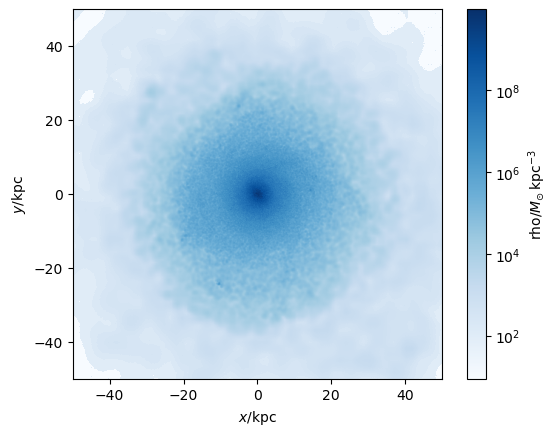

In [7]:
#Face on
pynbody.analysis.angmom.faceon(h[1])
pynbody.plot.image(h[1].s, width=100, cmap='Blues');

### Plot of h[2]

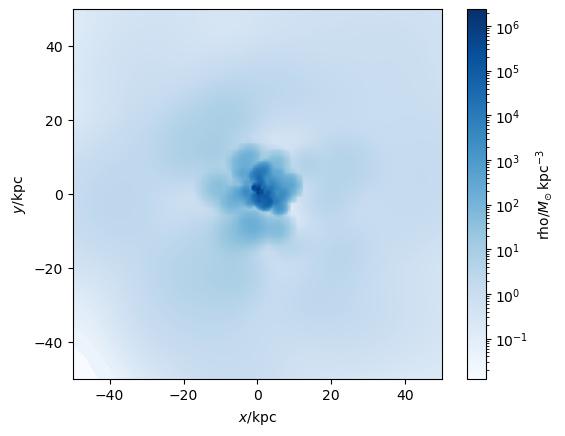

In [8]:
pynbody.analysis.halo.center(h[2],mode='hyb')
pynbody.plot.image(h[2].s, width=100, cmap='Blues');

### Profile of density and circular velocity

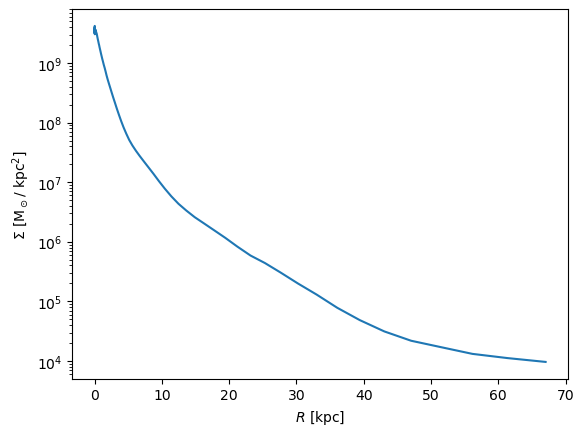

In [9]:
pynbody.analysis.angmom.faceon(h[1])
ps = pynbody.analysis.profile.Profile(h1.s, min = 0.01, max = 70, type = 'log')
plt.plot(ps['rbins'], ps['density'])
plt.semilogy()
plt.xlabel(r'$R$ [kpc]')
plt.ylabel(r'$\Sigma$ [M$_\odot$/ kpc$^2$]');

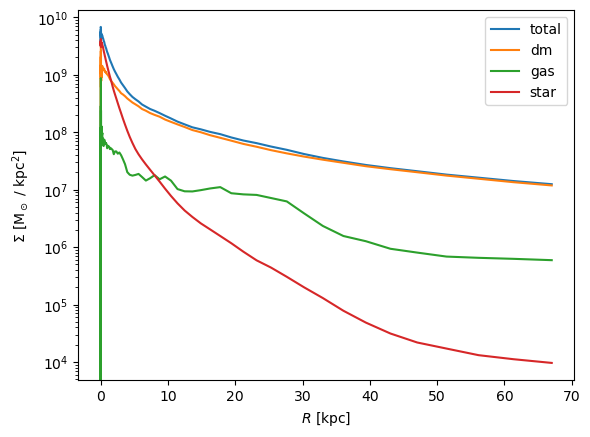

In [10]:
ps = pynbody.analysis.profile.Profile(h1.s, min=0.01, max=70, type='log')
pg = pynbody.analysis.profile.Profile(h1.g, min=0.01, max=70, type='log')
pd = pynbody.analysis.profile.Profile(h1.d, min=0.01, max=70, type='log')
p = pynbody.analysis.profile.Profile(h1, min=0.01, max=70, type='log')

for prof, name in zip([p, pd, pg, ps], ['total', 'dm', 'gas', 'star']):
    plt.plot(prof['rbins'], prof['density'], label=name)
plt.semilogy()
plt.legend()
plt.xlabel(r'$R$ [kpc]')
plt.ylabel(r'$\Sigma$ [M$_\odot$ / kpc$^2$]');

pynbody.analysis.profile : Profile v_circ -- this routine assumes the disk is in the x-y plane
pynbody.analysis.profile : Profile v_circ -- this routine assumes the disk is in the x-y plane
pynbody.analysis.profile : Profile v_circ -- this routine assumes the disk is in the x-y plane
pynbody.analysis.profile : Profile v_circ -- this routine assumes the disk is in the x-y plane


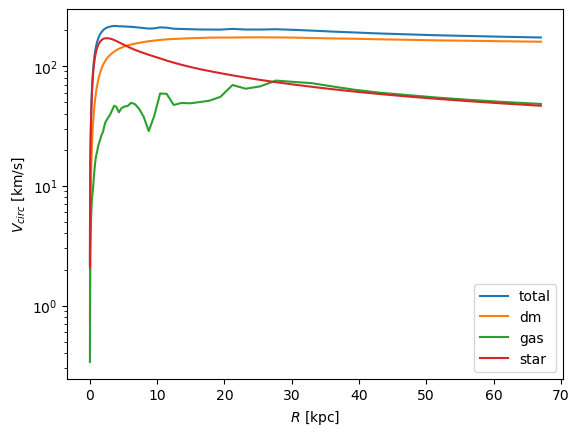

In [11]:
ps = pynbody.analysis.profile.Profile(h1.s, min=0.01, max=70, type='log')
pg = pynbody.analysis.profile.Profile(h1.g, min=0.01, max=70, type='log')
pd = pynbody.analysis.profile.Profile(h1.d, min=0.01, max=70, type='log')
p = pynbody.analysis.profile.Profile(h1, min=0.01, max=70, type='log')

for prof, name in zip([p, pd, pg, ps], ['total', 'dm', 'gas', 'star']):
    plt.plot(prof['rbins'], prof['v_circ'], label=name)
plt.semilogy()
plt.legend()
plt.xlabel(r'$R$ [kpc]')
plt.ylabel(r'$V_{circ}$ [km/s]');

# Distribution of the whole simulation (no distinction between different halos)

In [6]:
print(s.s.loadable_keys())

['mass', 'HI', 'FeMassFrac', 'pos', 'igasorder', 'timeform', 'massform', 'OxMassFrac', 'iord', 'phi', 'HeII', 'tform', 'eps', 'metals', 'vel', 'HeI']


In [7]:
print(s.derivable_keys())

['HII', 'HeIII', 'ne', 'hetot', 'hydrogen', 'feh', 'oxh', 'ofe', 'mgfe', 'nefe', 'sife', 'c_s', 'c_s_turb', 'mjeans', 'mjeans_turb', 'ljeans', 'ljeans_turb', 'r', 'rxy', 'vr', 'v2', 'vt', 'ke', 'te', 'j', 'j2', 'jz', 'vrxy', 'vcxy', 'vphi', 'vtheta', 'v_mean', 'v_disp', 'v_curl', 'vorticity', 'v_div', 'age', 'u_mag', 'u_lum_den', 'b_mag', 'b_lum_den', 'v_mag', 'v_lum_den', 'r_mag', 'r_lum_den', 'i_mag', 'i_lum_den', 'j_mag', 'j_lum_den', 'h_mag', 'h_lum_den', 'k_mag', 'k_lum_den', 'U_mag', 'U_lum_den', 'B_mag', 'B_lum_den', 'V_mag', 'V_lum_den', 'R_mag', 'R_lum_den', 'I_mag', 'I_lum_den', 'J_mag', 'J_lum_den', 'H_mag', 'H_lum_den', 'K_mag', 'K_lum_den', 'theta', 'alt', 'az', 'cs', 'mu', 'p', 'u', 'temp', 'zeldovich_offset', 'aform', 'tform', 'iord_argsort', 'smooth', 'rho']


In [8]:
h[1].properties.keys()

dict_keys(['omegaM0', 'omegaL0', 'h', 'boxsize', 'a', 'time', 'halo_id', 'ID', 'hostHalo', 'numSubStruct', 'mass', 'npart', 'Xc', 'Yc', 'Zc', 'VXc', 'VYc', 'VZc', 'Rvir', 'Rmax', 'r2', 'mbp_offset', 'com_offset', 'Vmax', 'v_esc', 'sigV', 'lambda', 'lambdaE', 'Lx', 'Ly', 'Lz', 'b_axis', 'c_axis', 'Eax', 'Eay', 'Eaz', 'Ebx', 'Eby', 'Ebz', 'Ecx', 'Ecy', 'Ecz', 'ovdens', 'nbins', 'fMhires', 'Ekin', 'Epot', 'SurfP', 'Phi0', 'cNFW', 'n_gas', 'M_gas', 'lambda_gas', 'lambdaE_gas', 'Lx_gas', 'Ly_gas', 'Lz_gas', 'b_gas', 'c_gas', 'Eax_gas', 'Eay_gas', 'Eaz_gas', 'Ebx_gas', 'Eby_gas', 'Ebz_gas', 'Ecx_gas', 'Ecy_gas', 'Ecz_gas', 'Ekin_gas', 'Epot_gas', 'n_star', 'M_star', 'lambda_star', 'lambdaE_star', 'Lx_star', 'Ly_star', 'Lz_star', 'b_star', 'c_star', 'Eax_star', 'Eay_star', 'Eaz_star', 'Ebx_star', 'Eby_star', 'Ebz_star', 'Ecx_star', 'Ecy_star', 'Ecz_star', 'Ekin_star', 'Epot_star', 'fstart', 'children'])

In [9]:
h[1].properties['numSubStruct']

171

In [10]:
print(h[1].properties['children'])

[3082, 315, 2658, 1001, 2613, 2895, 1426, 1514, 2925, 1159, 1104, 885, 1134, 572, 2303, 1342, 2771, 730, 1942, 2668, 841, 1882, 1392, 1294, 1495, 385, 2025, 916, 1814, 1778, 1811, 1947, 1732, 2872, 696, 2682, 2534, 1949, 2593, 257, 3007, 1939, 694, 723, 1146, 1381, 444, 892, 610, 2294, 2417, 281, 242, 2473, 559, 1430, 2140, 461, 316, 1565, 2280, 1261, 931, 1836, 2195, 2604, 277, 1255, 2087, 2806, 588, 2407, 2400, 1745, 2784, 1312, 633, 569, 1038, 1199, 1333, 2667, 1965, 218, 1935, 1369, 37, 2385, 2569, 1397, 1985, 1112, 486, 2282, 211, 119, 1610, 1894, 1386, 2601, 829, 2796, 1938, 2775, 3138, 2430, 2345, 546, 1406, 2853, 1584, 425, 1212, 1324, 721, 524, 2126, 2502, 3, 1086, 452, 386, 2339, 693, 353, 1709, 2139, 2891, 2432, 1149, 1921, 1786, 3008, 1250, 804, 2867, 154, 928, 1188, 2899, 521, 772, 617, 658, 3096, 1332, 2679, 897, 1815, 1826, 2193, 2789, 1483, 2226, 920, 2920, 992, 468, 1686, 888, 306, 507, 713, 1348, 2639, 2259, 2203, 1011, 715, 1660, 54]


In [11]:
h1_children_id, number_of_stars = [], []
for i in h[1].properties['children']:
    h1_children_id.append(i)
    number_of_stars.append(len(h[i].s))
h1_children = pd.DataFrame(data=(zip(h1_children_id, number_of_stars)), columns=('h1_children_index', 'number_of_stars'))
h1_children.head()

,h1_children_index,number_of_stars
0,3082,0
1,315,0
2,2658,0
3,1001,0
4,2613,0


In [12]:
host_halo_id = []
for i, h_i in enumerate(h):
    if h_i.properties['hostHalo'] == -1:
        host_halo_id.append(i+1)

print('Number of halos:', len(h))
print('Numeber of host_halo:', len(host_halo_id))

Number of halos: 3139
Numeber of host_halo: 2856


## Fe/H vs O/Fe 
Plot of [Fe/H] and [O/Fe] for different SolarNeighborhood parameters (R and z) filtering 

In [36]:
pynbody.analysis.halo.center(h[1],mode='hyb')

In [37]:
disk_filt = pynbody.filt.SolarNeighborhood(r1='0.00e+00 kpc', r2='3.00e+00 kpc', height='5.00e+00 kpc', cen=(0, 0, 0))

In [38]:
len(s[disk_filt])

2839247

In [39]:
feh = s[disk_filt].s['feh']
ofe = s[disk_filt].s['ofe']

print(len(s.s))
print(len(feh))
print(len(ofe))

4235419
2690312
2690312


In [40]:
feh_array = np.array(feh)
ofe_array = np.array(ofe)

#let's take the 99.9 percentile 
percentile_feh = np.percentile(feh_array, 0.1)
percentile_ofe = np.percentile(ofe_array, 0.1)
print(percentile_feh)
print(percentile_ofe)

-1.8651370884824654
-0.18545244270563124


In [41]:
df = pd.DataFrame(data=(zip(feh_array[feh_array>percentile_feh], ofe_array[ofe_array>percentile_ofe])),
                  columns= ['Fe/H', 'O/Fe'])

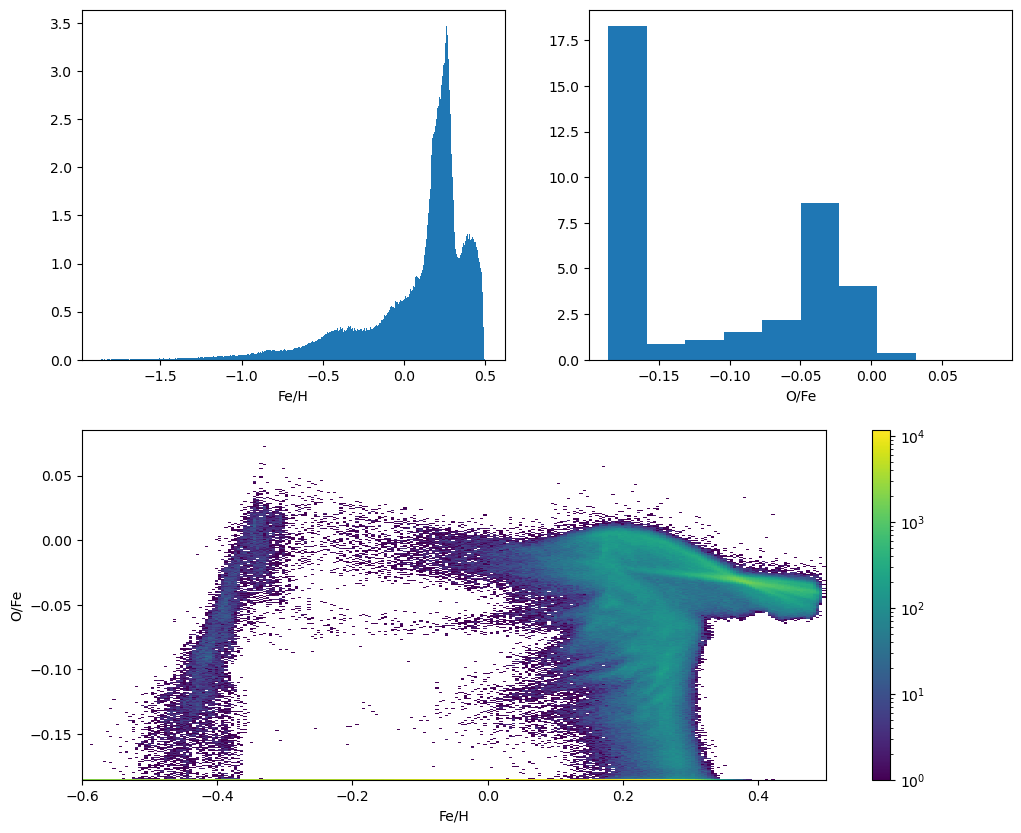

In [42]:
gs = gridspec.GridSpec(2, 2)

plt.figure(figsize=(12, 10))
ax = plt.subplot(gs[0,0]) 
plt.hist(df['Fe/H'], bins = 'sqrt', density=True)
plt.xlabel('Fe/H')

ax = plt.subplot(gs[0,1])
plt.hist(df['O/Fe'], density=True)
plt.xlabel('O/Fe')

ax = plt.subplot(gs[1, :])
plt.hist2d(df['Fe/H'], df['O/Fe'], bins=(500, 500), norm=matplotlib.colors.LogNorm())
plt.colorbar()
plt.xlabel('Fe/H')
plt.ylabel('O/Fe')
plt.xlim(-0.6, 0.5)
plt.show()

In [48]:
def plot_abbundance(r1, r2, height, n_percentile, gs_index):
    #filtering using pynbody.filt.SolarNeighborhood
    pynbody.analysis.halo.center(h1,mode='hyb')
    disk_filt = pynbody.filt.SolarNeighborhood(r1=f'{r1} kpc', r2=f'{r2} kpc', height=f'{height} kpc', cen=(0, 0, 0)) 
    feh = s[disk_filt].s['feh']
    ofe = s[disk_filt].s['ofe']
    
    feh_array = np.array(feh)
    ofe_array = np.array(ofe)
    #let's take the 99.9 percentile 
    percentile_feh = np.percentile(feh_array, n_percentile)
    percentile_ofe = np.percentile(ofe_array, n_percentile)
    
    #dataFrame for easy access
    df = pd.DataFrame(data=( zip(feh_array[feh_array>percentile_feh], ofe_array[ofe_array>percentile_ofe]) ), 
                      columns= ['Fe/H', 'O/Fe'])
    #plotting
    ax = plt.subplot(gs[gs_index])
    plt.hist2d(df['Fe/H'], df['O/Fe'], bins=(500, 500), norm=matplotlib.colors.LogNorm())
    plt.xlabel('[Fe/H]')
    plt.ylabel('[O/Fe]')
    plt.xlim(-0.8, 0.6)
    plt.ylim(-0.16, 0.058)
    x_ticks = ax.xaxis.get_major_ticks()
    x_ticks[-1].label1.set_visible(False)
    plt.colorbar(location='top', shrink=0.9)
    # plt.text(x = -0.2, y = 0.04, s=rf'{r1} < R < {r2} kpc')
    if gs_index != 0:
        plt.ylabel('')
        plt.tick_params(labelleft=False)
    return ax

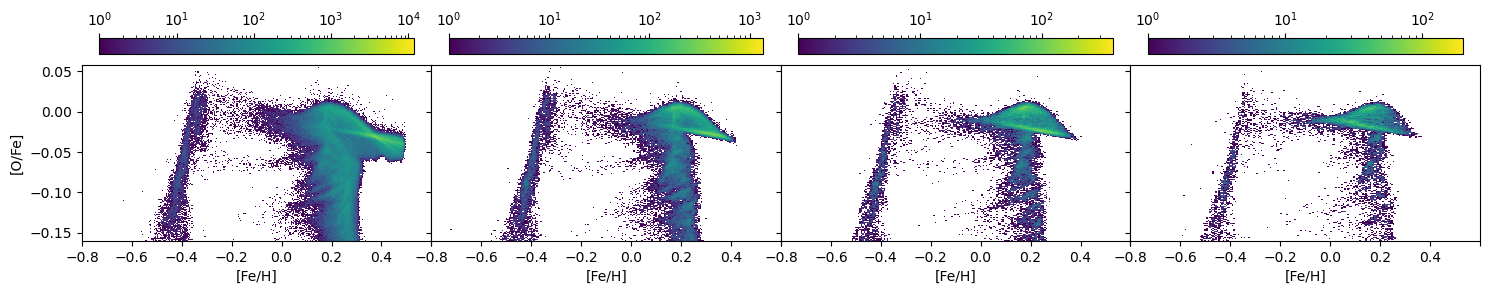

In [49]:
r_interval = [[0.001, 3.0], [3.0, 5.0], [5.0, 7.0], [7.0, 9.0]]
i=0
gs = gridspec.GridSpec(1, len(r_interval), wspace=0)
fig = plt.figure(figsize=(15, 3), tight_layout=True)
for r in r_interval:
    plot_abbundance(r[0], r[1], height=5, n_percentile=0.1, gs_index=i)
    i+=1
plt.show()

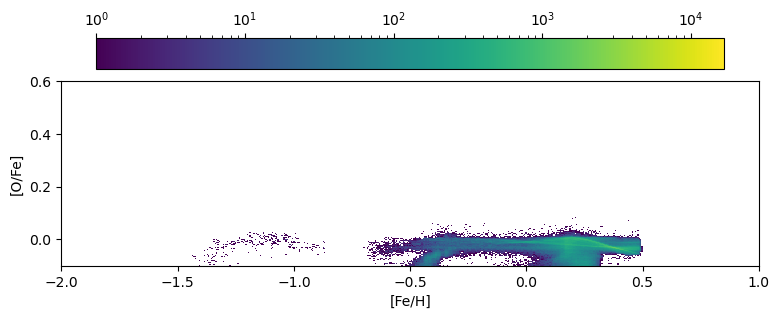

In [50]:
r_interval = [[0, 20]]
i=0
gs = gridspec.GridSpec(1, len(r_interval), wspace=0)
fig = plt.figure(figsize=(9, 3))
for r in r_interval:
    plot_abbundance(r[0], r[1], height=50, n_percentile=0.1, gs_index=i)
    i+=1

plt.xlim(-2, 1)
plt.ylim(-0.1, 0.6)
plt.show()

In [ ]:
cmap = plt.colormaps['magma']
norm = plt.cm.colors.LogNorm(vmin=0.0001, vmax=0.01)
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8, 3), sharey=True)

h0 = axs[0].hist2d(x, y, bins=(int(np.sqrt(N)), int(np.sqrt(N))),  density=True, cmap=cmap, norm=norm)
h1 = axs[1].hist2d(z, w, bins=(int(np.sqrt(T)), int(np.sqrt(T))),  density=True, cmap=cmap, norm=norm)

cbar = fig.colorbar(h0[3], ax=axs)

In [117]:
def plot_abbundance(fig, axs, r1, r2, height, n_percentile, num_figure, index):
        
    #filtering using pynbody.filt.SolarNeighborhood
    pynbody.analysis.halo.center(h1,mode='hyb')
    disk_filt = pynbody.filt.SolarNeighborhood(r1=f'{r1} kpc', r2=f'{r2} kpc', height=f'{height} kpc', cen=(0, 0, 0)) 
    feh = s[disk_filt].s['feh']
    ofe = s[disk_filt].s['ofe']
    
    feh_array = np.array(feh)
    ofe_array = np.array(ofe)
    #let's take the 99.9 percentile 
    percentile_feh = np.percentile(feh_array, n_percentile)
    percentile_ofe = np.percentile(ofe_array, n_percentile)
    
    #dataFrame for easy access
    df = pd.DataFrame(data=( zip(feh_array[feh_array>percentile_feh], ofe_array[ofe_array>percentile_ofe]) ), 
                      columns= ['Fe/H', 'O/Fe'])
    #plotting
    cmap = plt.colormaps['magma']
    norm = plt.cm.colors.LogNorm(vmin=0.0001, vmax=1e5)
    
    h = axs[index].hist2d(df['Fe/H'], df['O/Fe'], bins=(500, 500), norm=norm, cmap=cmap)
    axs[index].set_xlabel('[Fe/H]')
    axs[index].set_ylabel('[O/Fe]')
    
    axs[index].set_xlim(-0.8, 0.6)
    
    if index != 0:
        axs[index].set_ylabel('')
    
    if index == num_figure-1:
        cbar = fig.colorbar(h[3], ax=axs, location='top', orientation='horizontal', pad=0, fraction=0.1)
    
    return axs

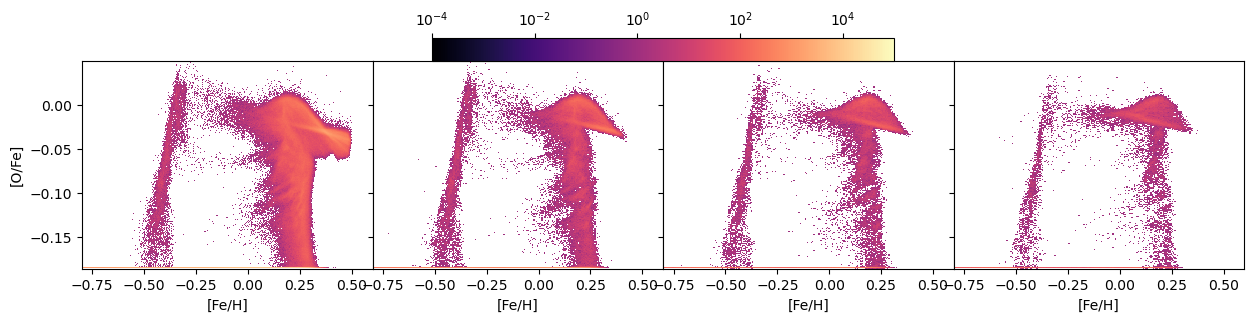

In [118]:
r_interval = [[0.001, 3.0], [3.0, 5.0], [5.0, 7.0], [7.0, 9.0]]
i=0
fig, axs = plt.subplots(nrows=1, ncols=len(r_interval), sharey=True, figsize=(15, 3))
plt.subplots_adjust(wspace=0)
for r in r_interval:
    plot_abbundance(fig, axs, r[0], r[1], height=5, n_percentile=0.1, num_figure=len(r_interval), index=i)
    i+=1
plt.show()